2/2 [==============================] - 1s 45ms/step
Epoch 0/1000 [D loss: 4.770921513438225 | D accuracy: 0.0] [G loss: 5.45855712890625]


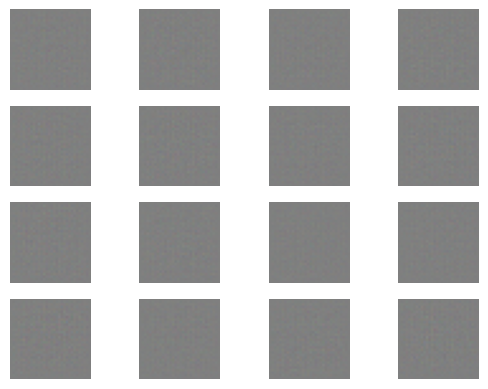

2/2 [==============================] - 0s 49ms/step
Epoch 100/1000 [D loss: -0.11752555519342422 | D accuracy: 0.0] [G loss: 0.0]


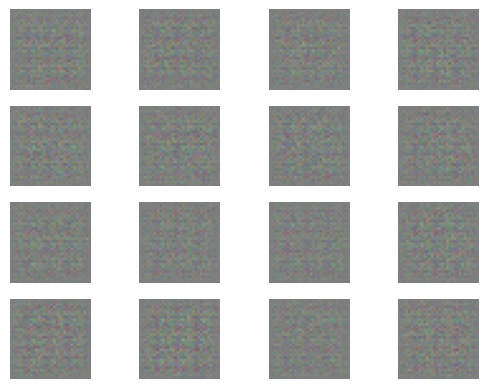

2/2 [==============================] - 0s 48ms/step
Epoch 200/1000 [D loss: 7.250553160905838 | D accuracy: 0.0] [G loss: 0.0]


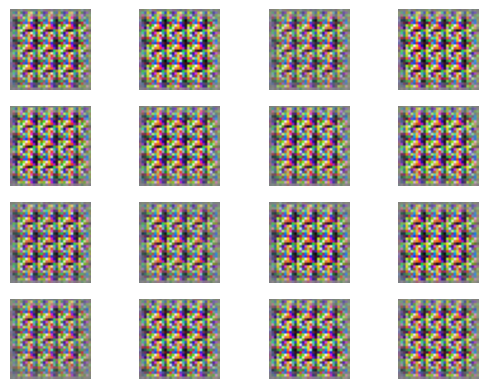

2/2 [==============================] - 0s 45ms/step
Epoch 300/1000 [D loss: 0.021270617842674255 | D accuracy: 0.0] [G loss: 15.424948692321777]


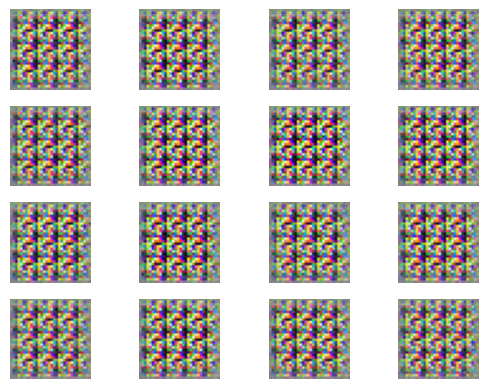

2/2 [==============================] - 0s 82ms/step
Epoch 400/1000 [D loss: 0.013491883873939514 | D accuracy: 0.0] [G loss: 15.424948692321777]


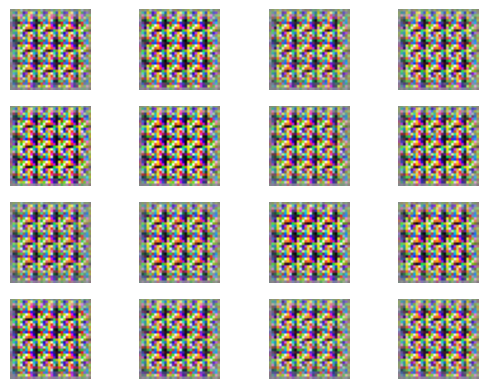

2/2 [==============================] - 0s 104ms/step
Epoch 500/1000 [D loss: 0.021868079900741577 | D accuracy: 0.0] [G loss: 15.424948692321777]


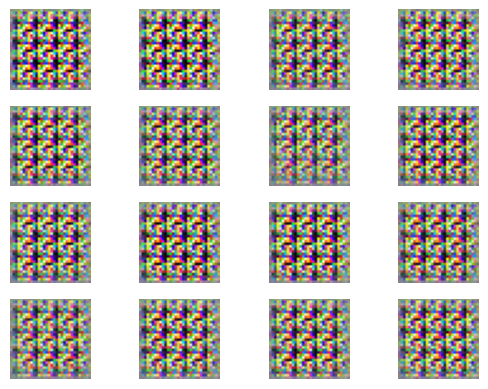

2/2 [==============================] - 0s 85ms/step
Epoch 600/1000 [D loss: -0.005937501788139343 | D accuracy: 0.0] [G loss: 15.424948692321777]


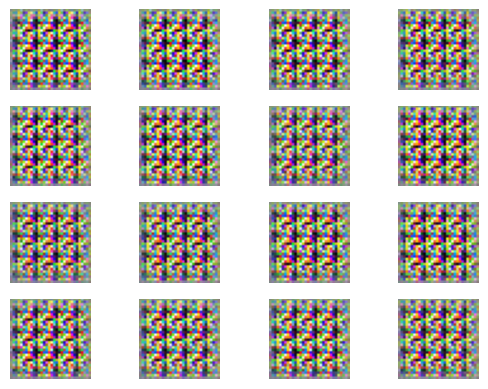

2/2 [==============================] - 0s 81ms/step
Epoch 700/1000 [D loss: 0.009499922394752502 | D accuracy: 0.0] [G loss: 15.424948692321777]


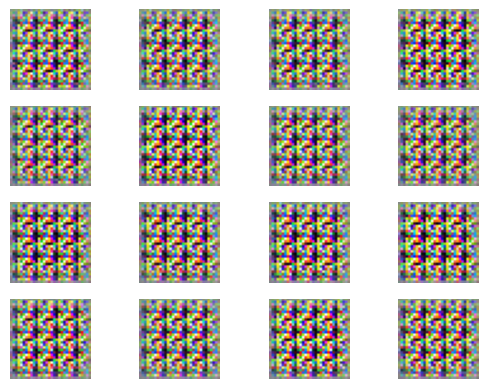

2/2 [==============================] - 0s 99ms/step
Epoch 800/1000 [D loss: 0.014730572700500488 | D accuracy: 0.0] [G loss: 15.424948692321777]


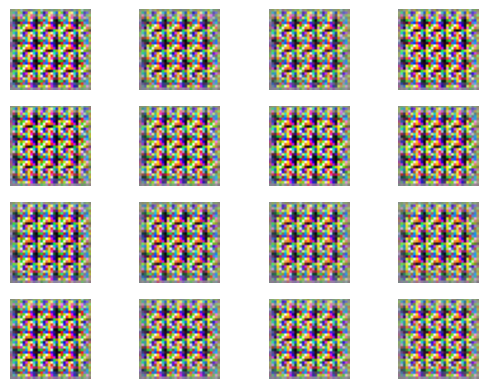

2/2 [==============================] - 0s 81ms/step
Epoch 900/1000 [D loss: -0.005866482853889465 | D accuracy: 0.0] [G loss: 15.424948692321777]


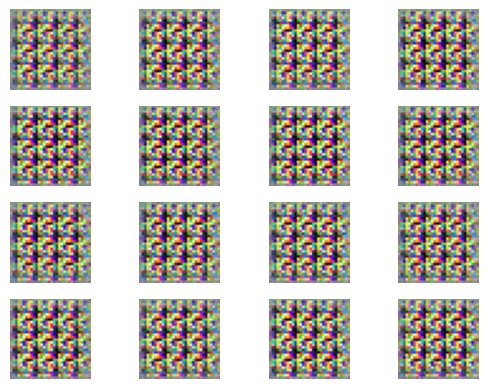

2/2 [==============================] - 0s 118ms/step


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(4 * 4 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Create the discriminator and generator
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# Compile the discriminator (Note: You can experiment with different optimizers and learning rates)
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Create the GAN by stacking the generator and discriminator
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)
gan = tf.keras.models.Model(gan_input, gan_output)

# Compile the GAN
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Training loop
epochs = 1000
batch_size = 64

for epoch in range(epochs):
    # Generate random noise as an input to the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

    # Generate fake images
    generated_images = generator.predict(noise)

    # Get a random batch of real images from the dataset
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_images = train_images[idx]

    # Combine real and fake images into a single array for training the discriminator
    combined_images = np.concatenate([real_images, generated_images])

    # Labels for real and fake images
    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    # Add random noise to the labels - this is a common practice to improve training stability
    labels_real += 0.05 * np.random.random(labels_real.shape)
    labels_fake += 0.05 * np.random.random(labels_fake.shape)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Generate random noise as an input to the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

    # Labels for generated images (pretend they are real)
    labels_gan = np.ones((batch_size, 1))

    # Train the generator (via the GAN model)
    g_loss = gan.train_on_batch(noise, labels_gan)

    # Print progress and save generated images at intervals
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # Generate and save images
        if epoch % 100 == 0:
            generated_images = generated_images * 0.5 + 0.5  # Rescale images to [0, 1]
            fig, axs = plt.subplots(4, 4)
            count = 0
            for i in range(4):
                for j in range(4):
                    axs[i, j].imshow(generated_images[count, :, :, :])
                    axs[i, j].axis('off')
                    count += 1
            plt.show()
